# Parameter Sweep Utilities Demonstration

This notebook demonstrates the comprehensive parameter sweep utilities for systematic exploration of the parameter space to identify optimal insurance configurations.

## Features Demonstrated
- Grid search across multiple parameter dimensions
- Parallel execution for efficient computation
- Result storage with HDF5/Parquet
- Optimal region identification
- Pre-defined scenario analysis
- Scenario comparison tools

Author: Alex Filiakov  
Date: 2025-08-29

In [1]:
# Import required libraries
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append(str(Path().absolute().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Import our modules
from src.parameter_sweep import ParameterSweeper, SweepConfig
from src.business_optimizer import BusinessOptimizer, BusinessConstraints
from src.manufacturer import WidgetManufacturer

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Basic Parameter Sweep

Let's start with a simple parameter sweep across company sizes and operating margins.

In [2]:
# Create a basic manufacturer using config
from src.config import ManufacturerConfig

# Create manufacturer configuration
config = ManufacturerConfig(
    initial_assets=10e6,
    working_capital_pct=0.2,  # 20% of assets
    asset_turnover_ratio=1.0,
    operating_margin=0.08,
    tax_rate=0.25,
    fixed_cost_ratio=0.08,  # 8% of revenue
    variable_cost_ratio=0.70,  # 70% of revenue
    production_capacity=100000,
    max_leverage_ratio=2.0,
    retention_ratio=0.6
)

# Create manufacturer
base_manufacturer = WidgetManufacturer(config)

# Create optimizer
optimizer = BusinessOptimizer(base_manufacturer)

# Initialize sweeper
sweeper = ParameterSweeper(
    optimizer=optimizer,
    cache_dir="./cache/parameter_sweeps",
    use_parallel=True
)

print("ParameterSweeper initialized successfully!")

ParameterSweeper initialized successfully!


In [3]:
# Define a simple parameter sweep
simple_config = SweepConfig(
    parameters={
        "initial_assets": [1e6, 5e6, 10e6, 20e6],
        "operating_margin": [0.05, 0.08, 0.10, 0.12],
        "asset_turnover": [0.8, 1.0, 1.2]
    },
    fixed_params={
        "time_horizon": 10,
        "n_simulations": 1000,  # Reduced for demo
        "max_risk_tolerance": 0.01,
        "min_roe_threshold": 0.10
    },
    n_workers=4,
    batch_size=10
)

# Estimate runtime
runtime_estimate = simple_config.estimate_runtime(seconds_per_run=2.0)
print(f"Estimated runtime: {runtime_estimate}")
print(f"Total parameter combinations: {len(simple_config.generate_grid())}")

Estimated runtime: 24s
Total parameter combinations: 48


In [4]:
# Execute the sweep (this may take a few minutes)
print("Starting parameter sweep...")
results = sweeper.sweep(simple_config)

print(f"\nSweep completed! Generated {len(results)} results")
print(f"\nColumns in results: {list(results.columns)}")
print(f"\nFirst few results:")
results.head()

Starting parameter sweep...


Parameter sweep: 100%|██████████| 48/48 [00:08<00:00,  5.76it/s]



Sweep completed! Generated 48 results

Columns in results: ['time_horizon', 'n_simulations', 'max_risk_tolerance', 'min_roe_threshold', 'initial_assets', 'operating_margin', 'asset_turnover', 'optimal_roe', 'baseline_roe', 'roe_improvement', 'ruin_probability', 'optimal_retention', 'optimal_limit', 'total_premium', 'optimal_deductible', 'sharpe_ratio', 'var_95', 'cvar_95']

First few results:


,time_horizon,n_simulations,max_risk_tolerance,min_roe_threshold,initial_assets,operating_margin,asset_turnover,optimal_roe,baseline_roe,roe_improvement,ruin_probability,optimal_retention,optimal_limit,total_premium,optimal_deductible,sharpe_ratio,var_95,cvar_95
0,10,1000,0.01,0.1,1000000.0,0.08,0.8,0.179394,0.143516,0.035879,0.006888,0.8,1.000192e+06,20010.588440,99386.080618,1.0,-0.1,-0.15
1,10,1000,0.01,0.1,1000000.0,0.05,0.8,0.182773,0.146219,0.036555,0.006957,0.8,1.000321e+06,20291.115040,100509.812478,1.0,-0.1,-0.15
2,10,1000,0.01,0.1,1000000.0,0.05,1.2,0.177822,0.142257,0.035564,0.005259,0.8,1.000778e+06,20078.056282,100971.219405,1.0,-0.1,-0.15
3,10,1000,0.01,0.1,1000000.0,0.05,1.0,0.180865,0.144692,0.036173,0.005452,0.8,1.000958e+06,17710.543255,101130.095279,1.0,-0.1,-0.15
4,10,1000,0.01,0.1,1000000.0,0.08,1.0,0.178946,0.143157,0.035789,0.005990,0.8,1.000174e+06,20449.637995,99499.509932,1.0,-0.1,-0.15


## 2. Optimal Region Identification

Now let's identify the optimal parameter regions based on ROE while constraining bankruptcy risk.

In [5]:
# Find optimal regions
optimal_results, param_summary = sweeper.find_optimal_regions(
    results,
    objective="optimal_roe",
    constraints={"ruin_probability": (0, 0.01)},  # Max 1% bankruptcy risk
    top_percentile=80  # Top 20% of results
)

print(f"Found {len(optimal_results)} optimal configurations")
print(f"\nParameter statistics for optimal region:")
print(param_summary)

Found 10 optimal configurations

Parameter statistics for optimal region:
                           min          max        mean           std  \
time_horizon             10.00        10.00       10.00  0.000000e+00   
n_simulations          1000.00      1000.00     1000.00  0.000000e+00   
max_risk_tolerance        0.01         0.01        0.01  1.828559e-18   
min_roe_threshold         0.10         0.10        0.10  0.000000e+00   
initial_assets      1000000.00  10000000.00  2300000.00  2.983287e+06   
operating_margin          0.05         0.12        0.09  2.666667e-02   
asset_turnover            0.80         1.00        0.88  1.032796e-01   

                        median  
time_horizon             10.00  
n_simulations          1000.00  
max_risk_tolerance        0.01  
min_roe_threshold         0.10  
initial_assets      1000000.00  
operating_margin          0.09  
asset_turnover            0.80  


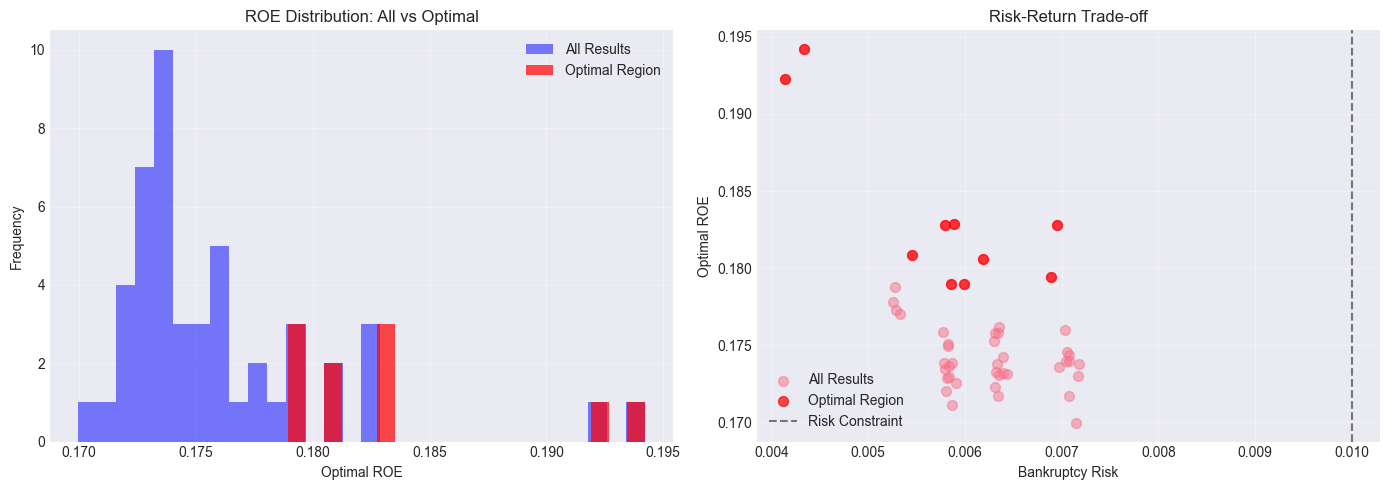

In [6]:
# Visualize optimal vs all results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROE distribution
axes[0].hist(results['optimal_roe'].dropna(), bins=30, alpha=0.5, label='All Results', color='blue')
axes[0].hist(optimal_results['optimal_roe'], bins=20, alpha=0.7, label='Optimal Region', color='red')
axes[0].set_xlabel('Optimal ROE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('ROE Distribution: All vs Optimal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot of ROE vs Risk
axes[1].scatter(results['ruin_probability'], results['optimal_roe'], 
                alpha=0.5, label='All Results', s=50)
axes[1].scatter(optimal_results['ruin_probability'], optimal_results['optimal_roe'], 
                color='red', alpha=0.7, label='Optimal Region', s=50)
axes[1].axvline(x=0.01, color='black', linestyle='--', alpha=0.5, label='Risk Constraint')
axes[1].set_xlabel('Bankruptcy Risk')
axes[1].set_ylabel('Optimal ROE')
axes[1].set_title('Risk-Return Trade-off')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Pre-defined Scenarios

The parameter sweep module includes several pre-defined scenarios for common analyses.

In [7]:
# Get pre-defined scenarios
scenarios = sweeper.create_scenarios()

print("Available pre-defined scenarios:")
for name, config in scenarios.items():
    n_combinations = len(config.generate_grid())
    print(f"\n{name}:")
    print(f"  - Parameters: {list(config.parameters.keys())}")
    print(f"  - Total combinations: {n_combinations}")
    print(f"  - Estimated runtime: {config.estimate_runtime(seconds_per_run=2.0)}")

Available pre-defined scenarios:

company_sizes:
  - Parameters: ['initial_assets', 'asset_turnover', 'operating_margin']
  - Total combinations: 27
  - Estimated runtime: 3s

loss_scenarios:
  - Parameters: ['loss_frequency', 'loss_severity_mu', 'loss_severity_sigma']
  - Total combinations: 27
  - Estimated runtime: 3s

market_conditions:
  - Parameters: ['premium_loading', 'tax_rate']
  - Total combinations: 9
  - Estimated runtime: 1s

time_horizons:
  - Parameters: ['time_horizon', 'initial_assets']
  - Total combinations: 12
  - Estimated runtime: 1s

simulation_scales:
  - Parameters: ['n_simulations', 'time_horizon']
  - Total combinations: 9
  - Estimated runtime: 1s


In [8]:
# Run company sizes scenario
company_sizes_config = scenarios["company_sizes"]
company_sizes_config.n_simulations = 500  # Reduce for demo

print("Running company sizes scenario...")
company_results = sweeper.sweep(company_sizes_config)

print(f"\nGenerated {len(company_results)} results")

# Analyze results by company size
size_analysis = company_results.groupby('initial_assets').agg({
    'optimal_roe': ['mean', 'std'],
    'ruin_probability': ['mean', 'std'],
    'optimal_retention': ['mean', 'std'],
    'total_premium': ['mean', 'std']
})

print("\nAnalysis by Company Size:")
print(size_analysis)

Running company sizes scenario...


Parameter sweep: 100%|██████████| 27/27 [00:14<00:00,  1.87it/s]



Generated 27 results

Analysis by Company Size:
               optimal_roe           ruin_probability            \
                      mean       std             mean       std   
initial_assets                                                    
1000000.0         0.182714  0.006908         0.006011  0.002470   
10000000.0        0.177228  0.005018         0.005811  0.001121   
100000000.0       0.179211  0.007185         0.005270  0.001045   

               optimal_retention      total_premium                 
                            mean  std          mean            std  
initial_assets                                                      
1000000.0                    0.8  0.0  1.825789e+04    6474.851629  
10000000.0                   0.8  0.0  1.308308e+05   53883.334554  
100000000.0                  0.8  0.0  1.174770e+06  698021.405379  


## 4. Heatmap Analysis

Visualize the parameter space as heatmaps to identify patterns and optimal regions.

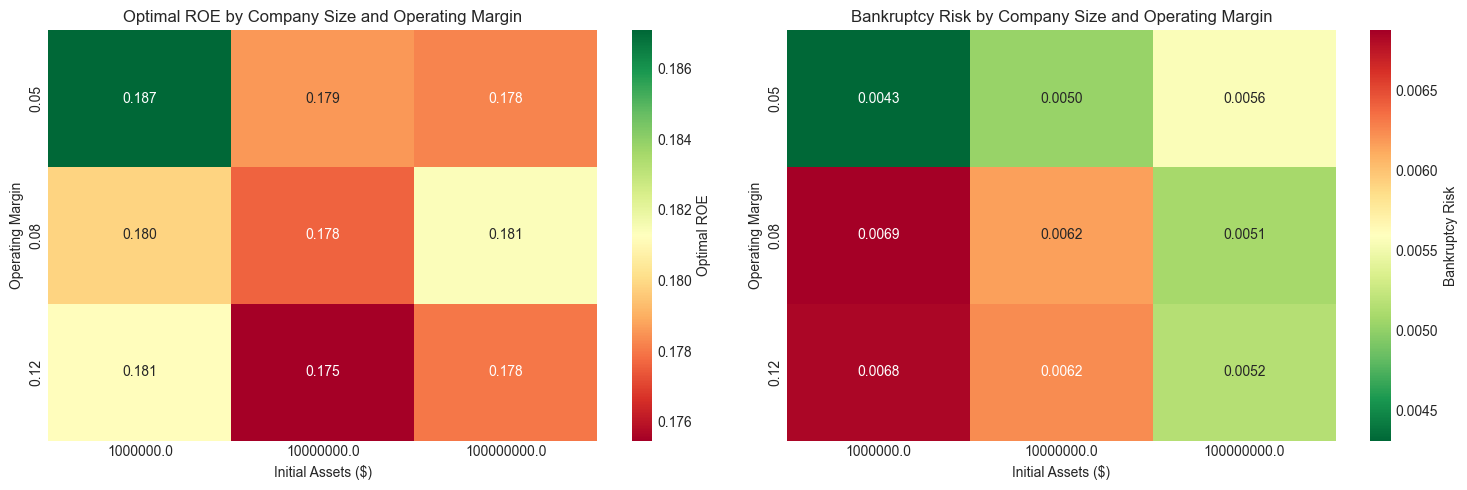

In [9]:
# Create pivot table for heatmap
# Average ROE for each combination of assets and operating margin
pivot_roe = company_results.pivot_table(
    values='optimal_roe',
    index='operating_margin',
    columns='initial_assets',
    aggfunc='mean'
)

pivot_risk = company_results.pivot_table(
    values='ruin_probability',
    index='operating_margin',
    columns='initial_assets',
    aggfunc='mean'
)

# Create heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROE heatmap
sns.heatmap(pivot_roe, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Optimal ROE'}, ax=axes[0])
axes[0].set_title('Optimal ROE by Company Size and Operating Margin')
axes[0].set_xlabel('Initial Assets ($)')
axes[0].set_ylabel('Operating Margin')

# Risk heatmap
sns.heatmap(pivot_risk, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Bankruptcy Risk'}, ax=axes[1])
axes[1].set_title('Bankruptcy Risk by Company Size and Operating Margin')
axes[1].set_xlabel('Initial Assets ($)')
axes[1].set_ylabel('Operating Margin')

plt.tight_layout()
plt.show()

## 5. Market Conditions Scenario

Analyze how different market conditions affect optimal insurance strategies.

In [10]:
# Run market conditions scenario
market_config = scenarios["market_conditions"]
market_config.fixed_params["n_simulations"] = 500  # Reduce for demo

print("Running market conditions scenario...")
market_results = sweeper.sweep(market_config)

print(f"\nGenerated {len(market_results)} results")

# Analyze by premium loading (soft vs hard market)
market_analysis = market_results.groupby('premium_loading').agg({
    'optimal_roe': 'mean',
    'total_premium': 'mean',
    'optimal_retention': 'mean'
})

print("\nAnalysis by Market Conditions (Premium Loading):")
print(market_analysis)

Running market conditions scenario...


Parameter sweep: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]



Generated 9 results

Analysis by Market Conditions (Premium Loading):
                 optimal_roe  total_premium  optimal_retention
premium_loading                                               
0.2                 0.174521  160350.870797                0.8
0.5                 0.175160  162124.844611                0.8
1.0                 0.175101  163233.671430                0.8


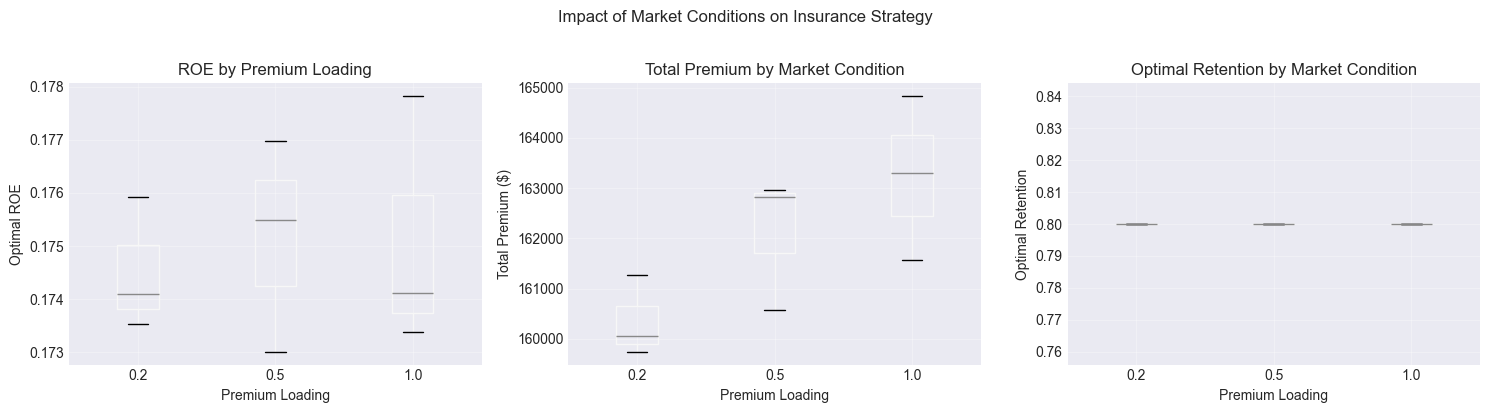

In [11]:
# Visualize market conditions impact
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ROE by premium loading
market_results.boxplot(column='optimal_roe', by='premium_loading', ax=axes[0])
axes[0].set_title('ROE by Premium Loading')
axes[0].set_xlabel('Premium Loading')
axes[0].set_ylabel('Optimal ROE')
axes[0].grid(True, alpha=0.3)

# Total premium by premium loading
market_results.boxplot(column='total_premium', by='premium_loading', ax=axes[1])
axes[1].set_title('Total Premium by Market Condition')
axes[1].set_xlabel('Premium Loading')
axes[1].set_ylabel('Total Premium ($)')
axes[1].grid(True, alpha=0.3)

# Retention by premium loading
market_results.boxplot(column='optimal_retention', by='premium_loading', ax=axes[2])
axes[2].set_title('Optimal Retention by Market Condition')
axes[2].set_xlabel('Premium Loading')
axes[2].set_ylabel('Optimal Retention')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Impact of Market Conditions on Insurance Strategy', y=1.02)
plt.tight_layout()
plt.show()

## 6. Scenario Comparison

Compare results across different scenarios to identify robust strategies.

In [12]:
# Collect results from different scenarios
scenario_results = {
    "Company Sizes": company_results,
    "Market Conditions": market_results
}

# Compare scenarios
comparison = sweeper.compare_scenarios(
    scenario_results,
    metrics=["optimal_roe", "ruin_probability", "total_premium"],
    normalize=True
)

print("Scenario Comparison:")
print(comparison)

Scenario Comparison:
                   optimal_roe_mean  optimal_roe_std  optimal_roe_min  \
scenario                                                                
Company Sizes              0.179718         0.006607         0.170476   
Market Conditions          0.174927         0.001705         0.173009   

                   optimal_roe_max  ruin_probability_mean  \
scenario                                                    
Company Sizes             0.200568               0.005697   
Market Conditions         0.177820               0.006331   

                   ruin_probability_std  ruin_probability_min  \
scenario                                                        
Company Sizes                  0.001644              0.002364   
Market Conditions              0.000032              0.006291   

                   ruin_probability_max  total_premium_mean  \
scenario                                                      
Company Sizes                  0.009899       441286.1

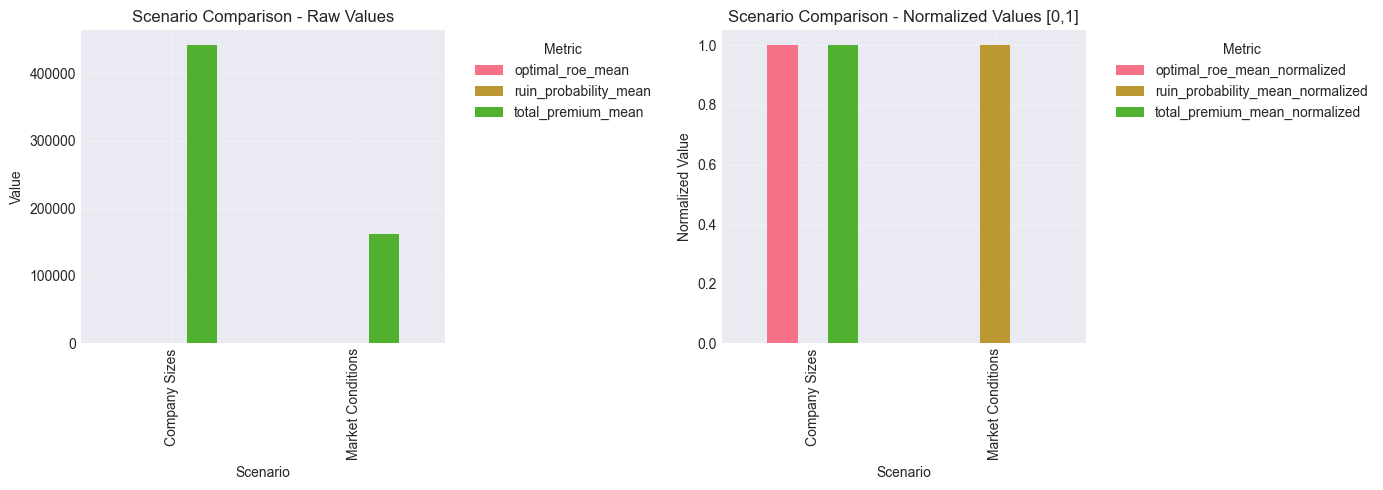

In [13]:
# Visualize scenario comparison
metrics_to_plot = ['optimal_roe_mean', 'ruin_probability_mean', 'total_premium_mean']
normalized_metrics = [f"{m}_normalized" for m in metrics_to_plot]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw values
comparison[metrics_to_plot].plot(kind='bar', ax=axes[0])
axes[0].set_title('Scenario Comparison - Raw Values')
axes[0].set_xlabel('Scenario')
axes[0].set_ylabel('Value')
axes[0].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# Normalized values
if all(col in comparison.columns for col in normalized_metrics):
    comparison[normalized_metrics].plot(kind='bar', ax=axes[1])
    axes[1].set_title('Scenario Comparison - Normalized Values [0,1]')
    axes[1].set_xlabel('Scenario')
    axes[1].set_ylabel('Normalized Value')
    axes[1].legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Export Results

Export the sweep results to various formats for further analysis.

In [14]:
# Create export directory
export_dir = Path("./exports/parameter_sweeps")
export_dir.mkdir(parents=True, exist_ok=True)

# Export to different formats
formats = {
    "parquet": "company_sizes_results.parquet",
    "csv": "company_sizes_results.csv",
    "hdf5": "company_sizes_results.h5"
}

for format_type, filename in formats.items():
    filepath = export_dir / filename
    sweeper.export_results(company_results, str(filepath), format=format_type)
    print(f"Exported to {format_type}: {filepath}")

# Also save optimal results
optimal_filepath = export_dir / "optimal_configurations.csv"
optimal_results.to_csv(optimal_filepath, index=False)
print(f"\nExported optimal configurations to: {optimal_filepath}")

HDF5 support not available (tables package missing). Using parquet instead.


Exported to parquet: exports\parameter_sweeps\company_sizes_results.parquet
Exported to csv: exports\parameter_sweeps\company_sizes_results.csv
Exported to hdf5: exports\parameter_sweeps\company_sizes_results.h5

Exported optimal configurations to: exports\parameter_sweeps\optimal_configurations.csv


## 8. Performance Analysis

Analyze the computational performance of the parameter sweep.

In [15]:
import time

# Test performance with different configurations
performance_tests = [
    {"n_workers": 1, "batch_size": 10},
    {"n_workers": 2, "batch_size": 20},
    {"n_workers": 4, "batch_size": 40},
]

# Small test configuration
test_config = SweepConfig(
    parameters={
        "initial_assets": [5e6, 10e6],
        "operating_margin": [0.08, 0.10],
        "asset_turnover": [0.9, 1.1]
    },
    fixed_params={
        "time_horizon": 5,
        "n_simulations": 100
    }
)

performance_results = []

for test in performance_tests:
    test_config.n_workers = test["n_workers"]
    test_config.batch_size = test["batch_size"]
    
    # Create new sweeper with specific parallel setting
    test_sweeper = ParameterSweeper(
        cache_dir="./cache/performance_test",
        use_parallel=(test["n_workers"] > 1)
    )
    
    start_time = time.time()
    _ = test_sweeper.sweep(test_config)
    elapsed_time = time.time() - start_time
    
    performance_results.append({
        "n_workers": test["n_workers"],
        "batch_size": test["batch_size"],
        "elapsed_time": elapsed_time,
        "configs_per_second": len(test_config.generate_grid()) / elapsed_time
    })
    
    print(f"Workers: {test['n_workers']}, Time: {elapsed_time:.2f}s")

# Display performance comparison
perf_df = pd.DataFrame(performance_results)
print("\nPerformance Comparison:")
print(perf_df)

Parameter sweep:   0%|          | 0/8 [00:00<?, ?it/s]

Parameter sweep:  38%|███▊      | 3/8 [00:00<00:00,  8.26it/s]

Parameter sweep:  62%|██████▎   | 5/8 [00:00<00:00, 10.04it/s]

Parameter sweep: 100%|██████████| 8/8 [00:00<00:00,  8.79it/s]


Workers: 1, Time: 0.94s


Parameter sweep: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Workers: 2, Time: 5.78s


Parameter sweep: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Workers: 4, Time: 6.43s

Performance Comparison:
   n_workers  batch_size  elapsed_time  configs_per_second
0          1          10      0.937593            8.532489
1          2          20      5.775906            1.385064
2          4          40      6.427581            1.244636


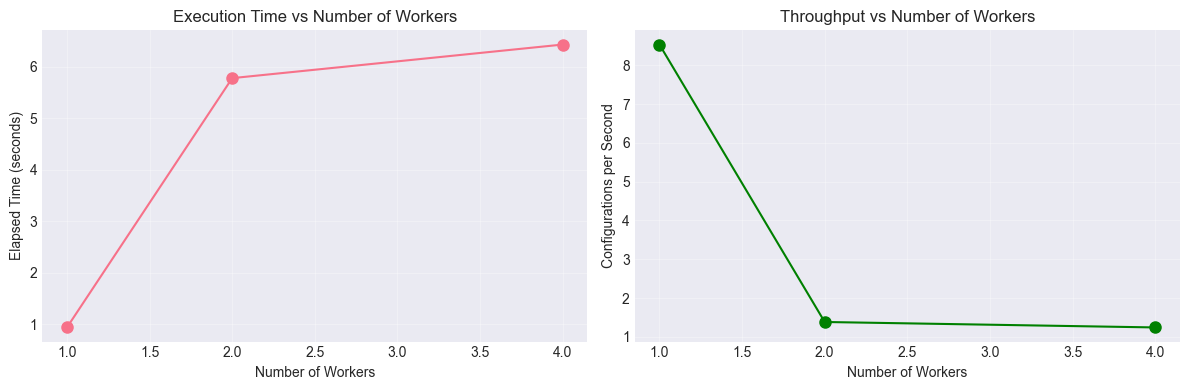


Speedup and Efficiency:
   n_workers   speedup  efficiency
0          1  1.000000    1.000000
1          2  0.162328    0.081164
2          4  0.145870    0.036468


In [16]:
# Visualize performance scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Execution time
axes[0].plot(perf_df['n_workers'], perf_df['elapsed_time'], 'o-', markersize=8)
axes[0].set_xlabel('Number of Workers')
axes[0].set_ylabel('Elapsed Time (seconds)')
axes[0].set_title('Execution Time vs Number of Workers')
axes[0].grid(True, alpha=0.3)

# Throughput
axes[1].plot(perf_df['n_workers'], perf_df['configs_per_second'], 'o-', markersize=8, color='green')
axes[1].set_xlabel('Number of Workers')
axes[1].set_ylabel('Configurations per Second')
axes[1].set_title('Throughput vs Number of Workers')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate speedup
baseline_time = perf_df[perf_df['n_workers'] == 1]['elapsed_time'].values[0]
perf_df['speedup'] = baseline_time / perf_df['elapsed_time']
perf_df['efficiency'] = perf_df['speedup'] / perf_df['n_workers']

print("\nSpeedup and Efficiency:")
print(perf_df[['n_workers', 'speedup', 'efficiency']])

## Summary

This notebook demonstrated the comprehensive parameter sweep utilities:

1. **Grid Search**: Systematic exploration of parameter combinations
2. **Parallel Execution**: Efficient computation using multiple workers
3. **Optimal Region Identification**: Finding best parameter configurations
4. **Pre-defined Scenarios**: Common analysis patterns ready to use
5. **Result Storage**: HDF5/Parquet support for large datasets
6. **Scenario Comparison**: Side-by-side analysis of different configurations
7. **Performance Scaling**: Efficient parallel processing

The parameter sweep utilities enable:
- Validation of robustness across scenarios
- Identification of optimal parameter regions
- Understanding of parameter sensitivities
- Efficient exploration of large parameter spaces